# Feature selection

* Non-greedy CV of all possible feature combinations

In the previous notebook, 1_feature_engineering, we created 2 new features. ```distance_dt``` (distance a listing is from downtown Seattle) and ```property_type_cleansed``` (simpified version of ```property_type``` with 8 instead of 37 levels).

In this notebook we will explore the effectiveness of these new features as well as the features we have already choosen for our yearly revenue estimator. To reiterate, we chose features that a perspective host would know about their listing, such as the number of people the listing can accommodate. Other features, such as super host and number of reviews was not taken into consideration since this information will not be available for someone wanting to list their Airbnb.

Feature selection has these potential benefits:

* Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.

* Improves Accuracy: Less misleading data means modeling accuracy improves.

* Reduces Training Time: fewer data points reduce algorithm complexity and algorithms train faster.

We want to choose either ```property_type_cleansed```, ```property_type```, or not even include it in the model. ```room_type``` might also be redundant.

```distance_dt```, the coordinate features, and neighborhood_group_cleansed are all related to the position of the listing which is problematic due to redundancy. We look to remove some or all of these features too.

```beds``` and ```bedrooms``` also seem redundant.

Recursive Feature Elimination (RFE)
with property_type, look to see if 'other' types are take out, if they are, this is an indication for property_type

# Imports

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, f_regression, SelectKBest, RFECV
from sklearn.linear_model import LassoCV, lasso_path
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
fp = os.path.join('..', 'data', 'interim', 'yearly_revenue.pkl')
listings = pd.read_pickle(fp)

# We also drop avg_booked_price and occupancy_rate because they are not know beforehand.
X = listings.drop(['avg_booked_price', 'occupancy_rate', 'yearly_revenue'], axis=1)
y = listings.yearly_revenue

# Train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [3]:
cv = KFold(5, shuffle=True, random_state=123)

# Correlation

Results:

* ```latitude```, ```longitude```, and ```distance_dt``` are not correlated with other variables
* Might not remove redundant and correlated variables because we know they ultimately affect the listing's price and yearly revenue.

All features except ```latitude```, ```longitude```, and ```distance_dt``` are highly correlated with each other. In terms of our response variable, ```bedrooms``` has the highest value of 0.548955.

Because of highly correlated variables, we might consider removing some redundancies, like ```bedrooms``` and ```beds```, but because of our knowledge of the subject, we expect that a listing with more beds should affect the nightly price, even if there is only one bedroom.

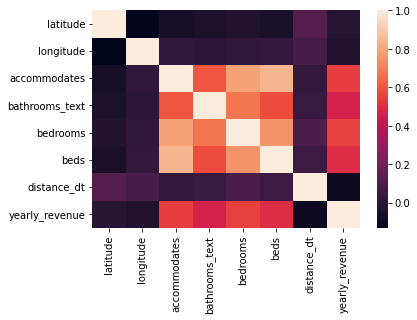

                latitude  longitude  accommodates  bathrooms_text  bedrooms  \
latitude        1.000000  -0.130896     -0.067705       -0.051225 -0.032586   
longitude      -0.130896   1.000000      0.016326        0.001012  0.012041   
accommodates   -0.067705   0.016326      1.000000        0.599194  0.790514   
bathrooms_text -0.051225   0.001012      0.599194        1.000000  0.675685   
bedrooms       -0.032586   0.012041      0.790514        0.675685  1.000000   
beds           -0.054710   0.019707      0.840298        0.580031  0.751901   
distance_dt     0.123537   0.082408      0.022272        0.037620  0.095860   
yearly_revenue -0.014134  -0.035395      0.543218        0.463442  0.548955   

                    beds  distance_dt  yearly_revenue  
latitude       -0.054710     0.123537       -0.014134  
longitude       0.019707     0.082408       -0.035395  
accommodates    0.840298     0.022272        0.543218  
bathrooms_text  0.580031     0.037620        0.463442  
bedrooms

In [4]:
train = X_train.join(y_train)
corr = train[train.describe().columns].corr()
sns.heatmap(corr)
plt.show()
print(corr)

# Univariate linear regression tests

Results:

*  Maybe get rid of ```distance_dt```, has a very high p-value of 0.95
* Maybe get rid of coordinates and just have ```distance_dt```
* ```bedrooms``` followed by ```accomodates``` are the most important in univariate analysis


F-test for linear regression tests whether the independent variables in a linear regression model are significant. 

f_regression in sklearn; for every single feature, it fits the single feature to the response variable and calculates an f score.

$H_0$: $\beta_1 = 0$; The coefficient is equal to 0 (Intercept model fits just as well)

$H_a$: $\beta_1 \neq 0$ The coefficient is not equal to 0 (Intercept model fits worse)

Statistically significant if p-value < 0.05, meaning we can reject the null hypothesis $H_0$ and can conclude that the independent variable fits better than a model with only the intercept. (There is a statistically significant relationship between the response and independent variable).


*Important reminder is that it will fail to capture any non-linear relationship and does not look at interactions between features \
*When performing univariate feature selection, it is best to separate continuous and categorical variables 

In [5]:
# Separate continuous and categorical.
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.drop(numerical_features, axis=1).columns

# Look at continuous features first.
sub_X_train = X_train.drop(categorical_features, axis=1)
preprocessor = ColumnTransformer(
    transformers=[('scalar', StandardScaler(), numerical_features)])
process_X_train = preprocessor.fit_transform(sub_X_train)

# Get p-values of each feature.
select = SelectKBest(f_regression, k=2)
select.fit(process_X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x14a863af0>)

In [6]:
def display_more(df, rows=None):
    """Displays any number or rows and sets back to default"""
    pd.set_option('display.max_rows', rows)
    display(df)
    pd.set_option('display.max_rows', 10)

ranked_features = pd.DataFrame({'features': sub_X_train.columns,
                                'p-value': select.pvalues_}).sort_values('p-value', ascending=False)
display_more(ranked_features)

,features,p-value
0,latitude,5.401165e-01
1,longitude,1.248932e-01
6,distance_dt,4.972583e-05
3,bathrooms_text,8.776615e-101
5,beds,2.171777e-119
2,accommodates,7.135647e-145
4,bedrooms,1.605727e-148


# L1-based feature selection

Results:

* Most important feature according to lasso is the level 'Room in aparthotel' from ```property_type```
* ```distance_dt``` has shrunk down to 0 while ```latitude``` and ```longitude``` have not
* ```bedrooms``` has shrunk down to 0 while ```beds``` has not.

Lasso involves a penalty term, which can shrink coefficient weights down to zero, essentially performing feature/variable selection.

In [7]:
# Create preprocessor that encodes categorical variables and scales numeric variables.
numerical_features = ['latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt']
categorical_features = X_train.drop(numerical_features, axis=1).columns
preprocessor = ColumnTransformer(
    transformers=[('onehot-encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                  ('scalar', StandardScaler(), numerical_features)])

# Preprocess and fit.
process_X_train = preprocessor.fit_transform(X_train)
clf = LassoCV(cv=cv)
sfm = SelectFromModel(clf)
sfm.fit(process_X_train, y_train)
n_features = sfm.transform(process_X_train).shape[1]

In [8]:
feature_names = numerical_features.copy()
feature_names.extend(preprocessor.transformers_[0][1].get_feature_names())
print('Number of features:', n_features)
display_more(pd.Series(feature_names)[sfm.get_support()])

Number of features: 22


0                     latitude
1                    longitude
2                 accommodates
3               bathrooms_text
5                         beds
11             x0_Central Area
12                 x0_Delridge
15                x0_Lake City
19               x0_Queen Anne
25                x1_Camper/RV
37             x1_Entire villa
53       x1_Room in aparthotel
57     x1_Shared room in house
59               x1_Tiny house
60          x2_Entire home/apt
64       x3_Entire condominium
65       x3_Entire guest suite
66        x3_Entire guesthouse
67             x3_Entire house
68         x3_Entire townhouse
69                    x3_Other
70    x3_Private room in house
dtype: object

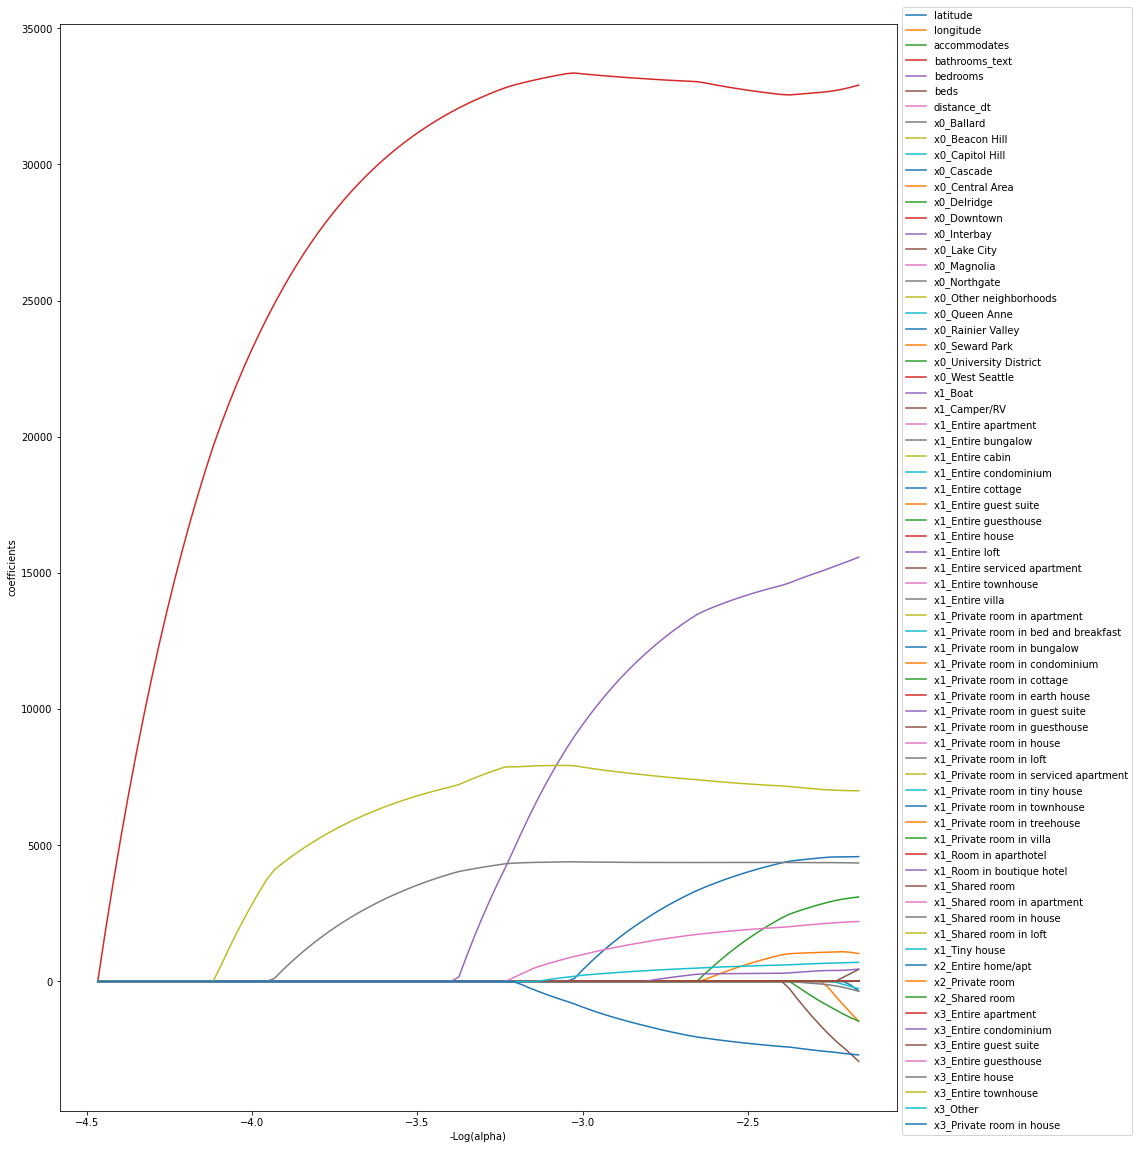

In [9]:
plt.figure(figsize=(15, 20))
eps = 5e-3
alphas_lasso, coefs_lasso, _ = lasso_path(process_X_train, y_train, eps=eps, fit_intercept=False)
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(neg_log_alphas_lasso, coef_l)
    plt.legend(feature_names, bbox_to_anchor=(1, 1.02))
    
plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')

plt.show()

# Recursive feature elimination with cross-validated selection

* Maybe get rid of ```property_type```; many of its levels are ranked the lowest
* Maybe get rid of ```neighbourhood_group_cleansed```. When using ```property_type_cleansed```, many of its levels are ranked the lowest

We find that many of the levels in ```property_type``` are ranked the worst out of all the features. When performing the same technique with ```property_type_cleansed```, the levels of property type were no longer the lowest-ranked  and instead levels of ```neighbourhood_group_cleansed``` were the worst ranked features.

This suggests that cleaning up ```property_type``` is a good idea, since it would reduce overfitting, and maybe we can take out ```neighbourhood_group_cleansed``` in favor of ```latitude``` and ```longitude```.

## With ```property_type```

In [10]:
# Look at with property_type first.
sub_X_train = X_train.drop('property_type_cleansed', axis=1)

# Create preprocessor that encodes categorical variables and scales numeric variables.
numerical_features = ['latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt']
categorical_features = sub_X_train.drop(numerical_features, axis=1).columns
preprocessor = ColumnTransformer(
    transformers=[('onehot-encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                  ('scalar', StandardScaler(), numerical_features)])

# Preprocess and fit.
process_X_train = preprocessor.fit_transform(sub_X_train)
selector = RFECV(RandomForestRegressor(random_state=123),
                cv=cv)
selector = selector.fit(process_X_train, y_train)

In [11]:
# Get feature names from OneHotEncoder to see which features rank high and low.
feature_names = numerical_features.copy()
feature_names.extend(preprocessor.transformers_[0][1].get_feature_names())

ranked_features = pd.DataFrame({'features': feature_names,
                                'rank': selector.ranking_}).sort_values('rank', ascending=False)
display_more(ranked_features.head(20))

,features,rank
0,latitude,1
47,x1_Private room in loft,1
34,x1_Entire loft,1
35,x1_Entire serviced apartment,1
36,x1_Entire townhouse,1
37,x1_Entire villa,1
38,x1_Private room in apartment,1
39,x1_Private room in bed and breakfast,1
40,x1_Private room in bungalow,1
41,x1_Private room in condominium,1


## With  ```property_type_cleansed```

In [12]:
# Look at with property_type_cleansed now
sub_X_train = X_train.drop('property_type', axis=1)

# Create preprocessor that encodes categorical variables and scales numeric variables.
numerical_features = ['latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt']
categorical_features = sub_X_train.drop(numerical_features, axis=1).columns
preprocessor = ColumnTransformer(
    transformers=[('onehot-encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                  ('scalar', StandardScaler(), numerical_features)])

# preprocess and fit
process_X_train = preprocessor.fit_transform(sub_X_train)
selector = RFECV(RandomForestRegressor(random_state=123),
                cv=cv)
selector = selector.fit(process_X_train, y_train)

In [13]:
# Get feature names from OneHotEncoder to see which features rank high and low.
feature_names = numerical_features.copy()
feature_names.extend(preprocessor.transformers_[0][1].get_feature_names())

ranked_features = pd.DataFrame({'features': feature_names,
                                'rank': selector.ranking_}).sort_values('rank', ascending=False)
display_more(ranked_features)

,features,rank
19,x0_Queen Anne,23
7,x0_Ballard,22
14,x0_Interbay,21
5,beds,20
8,x0_Beacon Hill,19
1,longitude,18
26,x1_Shared room,17
27,x2_Entire apartment,16
23,x0_West Seattle,15
6,distance_dt,14


# Cross validation feature selection

Results:

* Need at least one ```property_type```, ```property_type_cleansed```, and ```room_type```. When all dropped, the model suffers in performance
* ```property_type_cleansed``` performs slightly better than ```property_type``` and ```room_type```
* Prefer ```property_type_cleansed``` because it is granular but also more simple and decreases the risk of overfitting.

In this section, we will examine model performance when removing the features ```property_type```, ```property_type_cleansed```, and ```room_type```. We look at these features because they are related, ```property_type``` being a much more granular version of ```room_type```, while ```property_type_cleansed``` is in between the two in complexity.

This is necessary since RFE looks at the one-hot encoded features individually instead of a whole categorical column. This approach allows us to see the effect if the entire categorical column was removed.

For our base model, we will include all features and use a RandomForestRegressor. A base model is necessary to fully observe the change in performance between models We will then remove one of the features and examine the cross-validation scores.

## Baseline model

This will be the model that we will compare other models that only have a subset of features to.

In [14]:
# DataFrame to store metrics
mae_df = pd.DataFrame(columns=['mean_cv'])

numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.drop(numerical_features, axis=1).columns
preprocessor = ColumnTransformer(
    transformers=[('onehot-encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                  ('scalar', StandardScaler(), numerical_features)])
process_X_train = preprocessor.fit_transform(X_train)
base = RandomForestRegressor(random_state=123)
mae = -cross_val_score(base,
                        process_X_train,
                        y_train,
                        cv=cv,
                        n_jobs=-1,
                        scoring='neg_mean_absolute_error').mean()
mae_df = mae_df.append(pd.DataFrame({'mean_cv': mae}, index=['all_features']))

## Reduced models

According to our feature elimination test, the random forest model performs slightly better with ```property_type_cleansed``` than ```property_type``` or ```room_type```. One of the features is required in the model since the performance of the model suffers when all are dropped.

In [15]:
features_set = [['room_type', 'property_type_cleansed'],
                ['room_type', 'property_type'],
                ['property_type', 'property_type_cleansed', 'room_type'],
                ['property_type', 'property_type_cleansed']]

# Train models with different dropped features and store MAE in DataFrame.
for features in features_set:
    sub_X = X_train.drop(features, axis=1)

    categorical_features = sub_X.drop(numerical_features, axis=1).columns

    preprocessor = ColumnTransformer(
        transformers=[('onehot-encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                  ('scalar', StandardScaler(), list(numerical_features))])

    process_X = preprocessor.fit_transform(sub_X)


    rf = RandomForestRegressor(random_state=123)
    mae = -cross_val_score(rf,
                            process_X,
                            y_train,
                            cv=cv,
                            n_jobs=-1,
                            scoring='neg_mean_absolute_error').mean()
    mae_df = mae_df.append(pd.DataFrame({'mean_cv': mae}, index=[str(list(sub_X.columns))]))

In [16]:
mae_df

,mean_cv
all_features,11419.845863
"['neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt']",11558.768306
"['neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt', 'property_type_cleansed']",11502.895283
"['neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt']",12091.519327
"['neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt']",11556.165450


# Non-greedy feature combinations with cross-validation

Model all combinations of features with cross-validation, look at the feature set of the model that performs the best.



Results:

* Keep ```longitude``` and ```latitude``` over ```neighborhood_group_cleansed``` because they are less generalized and because we know location is very important to price (we want to know where downtown and not downtown in general)
* The best model uses ```latitude```, ```longitude```, ```property_type```, ```accommodates```, ```bathrooms_text```, ```beds```, ```distance_dt```, ```property_type_cleansed```


As opposed to a greedy approach such as sklearn's SequentialFeatureSelector we instead do a non-greedy approach, performing a brute force search of all possible feature combinations. This is done with a RandomForestRegressor with 5-fold cross-validation. The feature sets with the lowest mean cv scores should be considered more closely.

We highly advise against such an approach due to its computational expense, but this approach was considered due to our relatively few parameters (11) and the small data set (~2000 observations).

In [17]:
# These are the features we will drop.
feature_combos = []
for i in range(3, len(X.columns)):
    combos = list(itertools.combinations(X.columns, i))
    feature_combos.extend(combos)

# Number of unique combinations of features
len(feature_combos)

1980

In [18]:
%%time
rf = RandomForestRegressor(random_state=123)
features_df = pd.DataFrame(columns=['mean_cv'])

# Train different models with different feature sets and store MAE in DataFrame.
for features in feature_combos:
    
    sub_X = X.drop(list(features), axis=1)

    numerical_features = {'latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt'}
    num_cols = numerical_features.intersection(sub_X.columns)
    categorical_features = sub_X.drop(num_cols, axis=1).columns

    preprocessor = ColumnTransformer(
        transformers=[('onehot-encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                  ('scalar', StandardScaler(), list(num_cols))])
    
    process_X = preprocessor.fit_transform(sub_X)
    
    mae = -cross_val_score(rf,
                            process_X,
                            y,
                            cv=cv,
                            n_jobs=-1,
                            scoring='neg_mean_absolute_error').mean()
    
    features_df = features_df.append(pd.DataFrame({'mean_cv': mae}, index=[str(features)]))

CPU times: user 25.6 s, sys: 1.55 s, total: 27.1 s
Wall time: 25min 54s


In [19]:
features_df.sort_values('mean_cv')

,mean_cv
"('property_type', 'beds', 'distance_dt')",11502.770791
"('beds', 'distance_dt', 'property_type_cleansed')",11534.973565
"('accommodates', 'distance_dt', 'property_type_cleansed')",11540.333626
"('property_type', 'accommodates', 'distance_dt')",11543.553155
"('neighbourhood_group_cleansed', 'accommodates', 'distance_dt', 'property_type_cleansed')",11552.290768
...,...
"('longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt', 'property_type_cleansed')",18642.589340
"('latitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt', 'property_type_cleansed')",18773.341840
"('neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'property_type_cleansed')",19552.771321
"('neighbourhood_group_cleansed', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'distance_dt', 'property_type_cleansed')",20050.849926


# Conculsion

After looking through multiple methods of feature selection, we have decided to remove ```neighborhood_grouped_cleansed``` in favor of ```latitude``` and ```longitude```. We will also get rid of ```property_type``` and ```room_type``` in favor of ```property_type_cleansed```.
There was little to no evidence for ```distance_dt``` so we get rid of it due to it being redundant to ```neighborhood_grouped_cleansed```, ```latitude```, and ```longitude```

# Export model

In [20]:
processed_listings = listings.drop(['avg_booked_price', 'occupancy_rate', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'distance_dt'], axis=1)

In [21]:
fp = os.path.join('..', 'data', 'processed', 'yearly_revenue.pkl')
pd.to_pickle(processed_listings, fp)